<a href="https://colab.research.google.com/github/JJJJeon/ESAA/blob/main/OB_1%EC%A3%BC%EC%B0%A8_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3. 분류**
###**1. MNIST** 

In [2]:
# MINST 데이터셋 내려받기
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784',version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

사이킷런에서 읽어 들인 데이터셋들은 일반적으로 비슷한 딕셔너리 구조 가짐


*   데이터셋을 설명하는 DESCR 키
*   샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
*   레이블 배열을 담은 target 키



In [3]:
# 배열 살펴보기
X,y=mnist['data'],mnist['target']
print(X.shape)
print(y.shape)
# 70000개의 이미지, 784개의 특성(픽셀 강도)

(70000, 784)
(70000,)


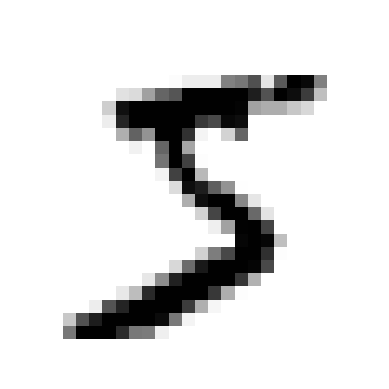

In [4]:
# 이미지 하나 확인
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit=X[0]
some_digit_image=some_digit.reshape(28,28)

plt.imshow(some_digit_image,cmap='binary')
plt.axis('off')
plt.show()

In [5]:
# 실제 레이블 확인
y[0] # 레이블은 문자열

'5'

In [6]:
# 정수로 변환
import numpy as np
y=y.astype(np.uint8)

In [7]:
X_train,X_test, y_train,y_test=X[:60000],X[60000:],y[:60000],y[60000:]

##**2. 이진 분류기 훈련** 

In [8]:
# '5-감지기': '5'와 '5 아님' 두 개의 클래스를 구분할 수 있는 이진 분류기
y_train_5=(y_train==5) # 5는 True고, 다른 숫자는 모두 False
y_test_5=(y_test==5)

In [9]:
# 확률적 경사 하강법 (매우 큰 데이터셋을 효율적으로 처리)
from sklearn.linear_model import SGDClassifier

sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [10]:
# 이 모델로 숫자 5의 이미지 감지
sgd_clf.predict([some_digit])

array([ True])

## **3. 성능 측정**
### 1. 교차 검증을 사용한 정확도 측정

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds=StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf=clone(sgd_clf)
  X_train_folds=X_train[train_index]
  y_train_folds=y_train_5[train_index]
  X_test_fold=X_train[test_index]
  y_test_fold=y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred=clone_clf.predict(X_test_fold)
  n_correct=sum(y_pred==y_test_fold)
  print(n_correct/len(y_pred))

0.95035
0.96035
0.9604


In [13]:
# 폴드가 3개인 k-겹 교차 검증
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [14]:
# 모든 이미지를 '5 아님'클래스로 분류하는 더미 분류기 만들어 비교
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [16]:
# 정확도 추측
never_5_clf=Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
# 이미지의 10% 정도만 숫자 5.. 
# 특히 불균형한 데이터셋을 다룰 때 정확도를 분류기의 성능 측정 지표로 선호하지 않음

array([0.91125, 0.90855, 0.90915])

### 2. 오차 행렬
클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것

In [17]:
# 오차 행렬 만들기 위해 예측값 만들기
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
# 각 테스트 폴드에서 얻은 예측 반환

In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)
# 행: 실제 클래스, 열: 예측한 클래스

array([[53892,   687],
       [ 1891,  3530]])

In [19]:
y_train_perfect_predictions = y_train_5 # 완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

*   정밀도: 양성 예측의 정확도 = TP / (TP+FP)
*   재현율=민감도=진짜 양성 비율: 분류기가 정확하게 감지한 양성 샘플의 비율 = TP / (TP+FN)

### 3. 정밀도와 재현율



In [20]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 3530 / (3530+687)

0.8370879772350012

In [21]:
recall_score(y_train_5, y_train_pred) # == 3530 / (3530 + 1891)

0.6511713705958311

* F1 점수: 정밀도와 재현율의 조화 평균 (정밀도와 
재현율이 비슷한 분류기에서 점수 높음)

 = TP / TP+(FN+FP)/2

In [22]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### 4. 정밀도/재현율 트레이드오프

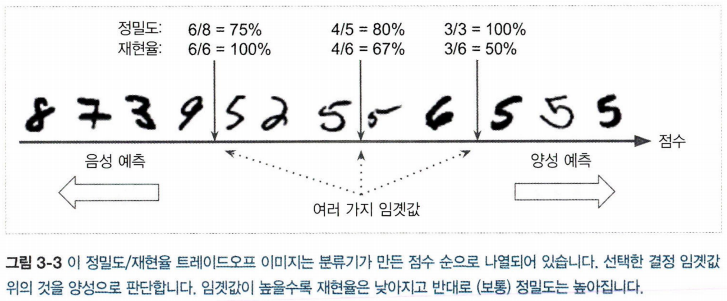

In [23]:
y_scores=sgd_clf.decision_function([some_digit]) # 각 샘플의 점수를 얻어 이 점수를 기반으로 원하는 임곗값 정해 예측 만들기
y_scores

array([2164.22030239])

In [24]:
threshold=0 # 임곗값 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [25]:
# 임곗값 높이기
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [26]:
## 적절한 임곗값 정하기
# 훈련 세트에 있는 모든 샘플의 결정 점수 반환
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method = "decision_function")

In [27]:
# 가능한 모든 임곗값에 대해 정밀도와 재현율 계산
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44247 (\N{HANGUL SYLLABLE GYES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


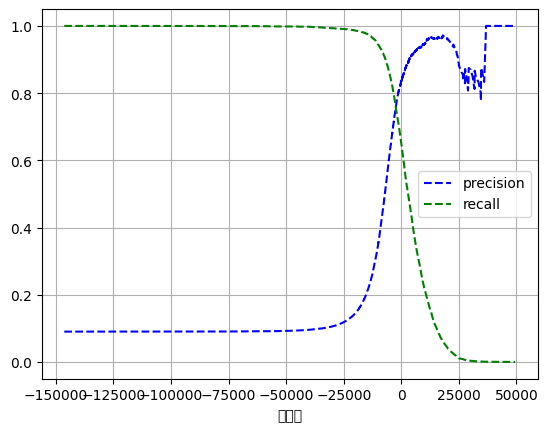

In [28]:
# 임곗값의 함수로 정밀도와 재현율 그리기
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="precision")
  plt.plot(thresholds, recalls[:-1], "g--", label="recall")
  plt.legend()
  plt.xlabel('임곗값')
  plt.grid()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [29]:
# 최소한 90% 정밀도가 되는 가장 낮은 임곗값
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [30]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [31]:
print(precision_score(y_train_5, y_train_pred_90), recall_score(y_train_5, y_train_pred_90))

0.9000345901072293 0.4799852425751706


### 5. ROC 곡선
거짓 양성 비율에 대한 진짜 양성 비율의 곡선

민감도(재현율)에 대한 1-특이도(TNR) 그래프

In [32]:
# 먼저 여러 임곗값에서 TPR, FPR 계산
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

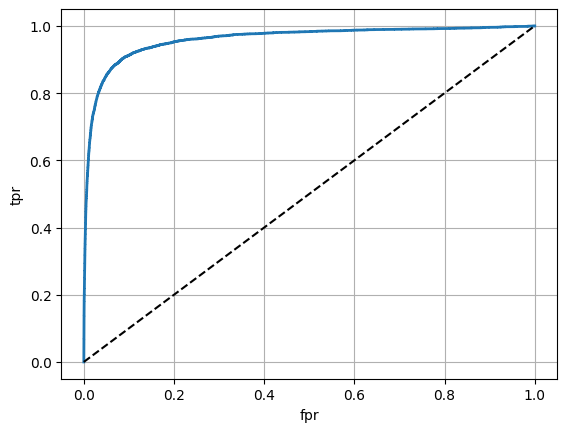

In [37]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--') # 대각 점선: 완전한 랜덤 분류기의 ROC 곡선. 이 점선에서 최대한 멀리 떨어져 있어야 좋은 분류기
  plt.xlabel('fpr')
  plt.ylabel('tpr')
  plt.grid()

plot_roc_curve(fpr, tpr)
plt.show()

# 트레이드 오프 - 재현율이 높을수록 분류기가 만드는 거짓 양성 늘어남

In [39]:
# 곡선 아래의 면적(AUC) 측정: 완벽한 분류기 1, 완전한 랜덤 분류기 0.5
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [41]:
from sklearn.ensemble import RandomForestClassifier

forest_clf=RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba") 
# 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열 반환

In [42]:
y_scores_forest = y_probas_forest[:, 1] # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

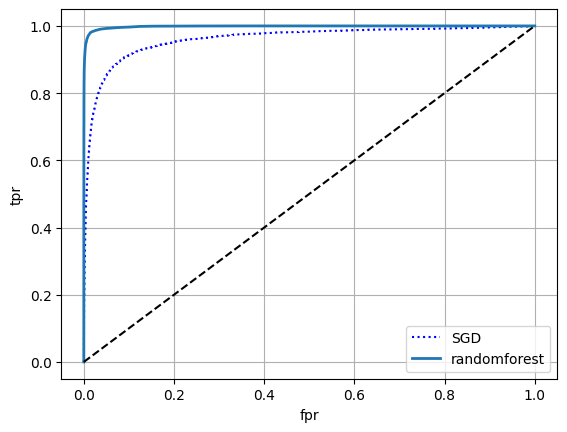

In [44]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "randomforest")
plt.legend(loc="lower right")
plt.show()
# RandomForestClassifier의 ROC 곡선이 왼쪽 위 모서리에 더 가까워 SGDClassifier보다 훨씬 좋아 보임

In [45]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

###**4. 다중 분류**
둘 이상의 클래스 구별


*   OvR 또는 OvA 전략: 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택
*   OvO 전략: 각 숫자의 조합마다 이진 분류기를 훈련 (클래스가 N개라면 분류기는 N*(N-1)/2개 필요), 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 필요하다는 장점이 있음



In [46]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train_5가 아니고 y_train을 사용
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [47]:
some_digit_scores=svm_clf.decision_function([some_digit]) # 샘플 당 10개의 점수 반환
some_digit_scores
# 가장 높은 점수가 클래스 5에 해당하는 값

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [48]:
np.argmax(some_digit_scores)

5

In [49]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [50]:
svm_clf.classes_[5]

5

In [51]:
# SVC 기반으로 OvR 전략을 사용하는 다중 분류기
from sklearn.multiclass import OneVsRestClassifier # OvO나 OvR을 사용하도록 강제
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [52]:
len(ovr_clf.estimators_)

10

In [53]:
sgd_clf.fit(X_train, y_train) # SGD 분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 별도로 OvR이나 OvO를 적용할 필요 없음
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [54]:
sgd_clf.decision_function([some_digit]) # 클래스마다 하나의 값 반환
# 분류기가 예측 결과에 강한 확신을 보이고 있음

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [55]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [56]:
# 간단하게 입력의 스케일 조정하여 정확도 올리기
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

### **5. 에러 분석**
가능성이 높은 모델을 하나 찾았다고 가정하고 이 모델의 성능을 향상시킬 방법

In [57]:
y_train_pred=cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx=confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

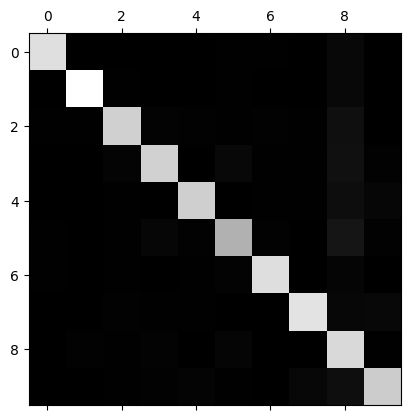

In [58]:
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()
# 숫자 5가 조금 어두워 보임: 숫자 5의 이미지가 적거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못함

In [59]:
row_sums=conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx= conf_mx/row_sums # 오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율 비교

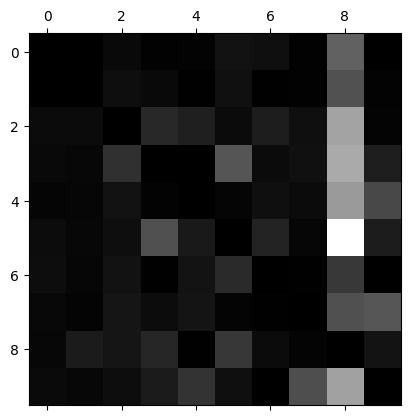

In [60]:
np.fill_diagonal(norm_conf_mx,0) # 다른 항목 유지하고 주대각선만 0으로 채우기
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)
plt.show()
# 클래스 8의 열이 상당히 밝음 -> 많은 이미지가 8로 잘못 분류됨
# 클래스 8의 행은 그리 나쁘지 않음 -> 실제 8이 적절히 8로 분류됨됨

In [61]:
def plot_digits(instances, images_per_row=10, **options): # 맷플롯립의 imshow() 함수 사용하는 함수
  size=28
  images_per_row=min(len(instances), images_per_row)
  images=[instance.reshape(size, size) for instance in instances]
  n_rows=(len(instances)-1)//images_per_row+1
  row_images=[]
  n_empty=n_rows*images_per_row-len(instances)
  images.append(np.zeros((size,size*n_empty)))
  for row in range(n_rows):
    rimages=images[row*images_per_row:(row+1)*images_per_row]
    row_images.append(np.concatenate(rimages,axis=1))
  image=np.concatenate(row_images, axis=0)
  plt.imshow(image, cmap=mpl.cm.binary, **options)
  plt.axis('off')

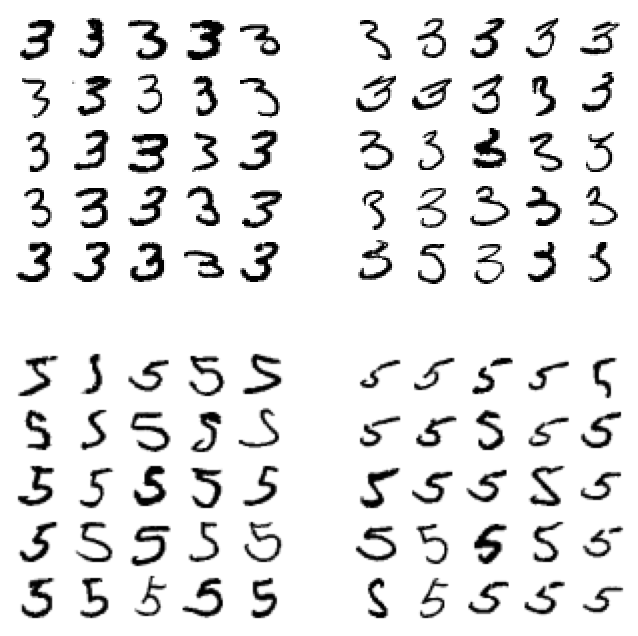

In [62]:
cl_a, cl_b=3,5
X_aa=X_train[(y_train ==cl_a)&(y_train_pred==cl_a)]
X_ab=X_train[(y_train ==cl_a)&(y_train_pred==cl_b)]
X_ba=X_train[(y_train ==cl_b)&(y_train_pred==cl_a)]
X_bb=X_train[(y_train ==cl_b)&(y_train_pred==cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

실수한 원인: 선형 모델인 SGDClassifier를 사용했기 때문. 선형 분류기는 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산하는데 3과 5는 몇 개의 픽셀만 다르기 때문

-> 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리 하는 것이 에러를 줄이는 한 가지 방법

### **6. 다중 레이블 분류**
여러 개의 이진 꼬리표를 출력하는 분류 시스템

In [63]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large=(y_train>=7) # 숫자가 큰 값 (7,8,9)인지 나타냄
y_train_odd=(y_train%2==1) # 홀수인지 나타냄
y_multilabel=np.c_[y_train_large,y_train_odd] # 각 숫자 이미지에 두 개의 타겟 레이블이 담김

knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [64]:
knn_clf.predict([some_digit]) # 숫자 5는 크지 않고(False) 홀수(True)

array([[False,  True]])

In [65]:
# 모든 레이블에 대한 F1 점수의 평균 계산 (모든 레이블의 가중치 같다고 가정)
y_train_knn_pred=cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")
# average='weighted': 레이블에 클래스의 지지도를 가중치로 주는 것

0.976410265560605

### **7. 다중 출력 분류**
다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것

In [66]:
noise = np.random.randint(0,100,(len(X_train),784)) # 픽셀 강도에 잡음 추가가
X_train_mod = X_train + noise
noise = np.random.randint(0,100,(len(X_test),784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [67]:
def plot_digit(data):
  image=data.reshape(28,28)
  plt.imshow(image,cmap=mpl.cm.binary,
             interpolation='nearest')
  plt.axis('off')

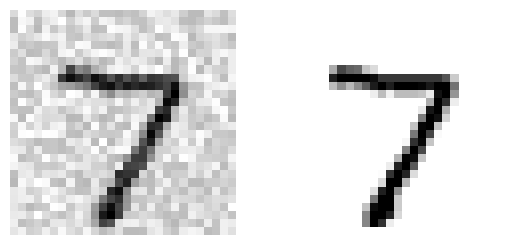

In [71]:
some_index=0
plt.subplot(121);plot_digit(X_test_mod[some_index])
plt.subplot(122);plot_digit(X_test[some_index])
plt.show()
# 잡음이 섞인 입력 이미지 / 깨끗한 타깃 이미지

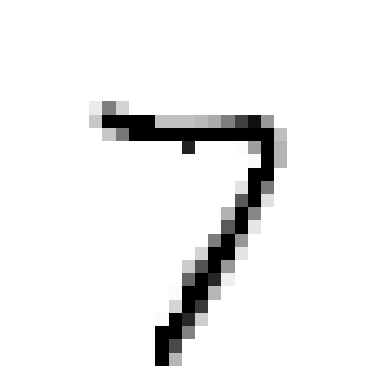

In [72]:
# 분류기 훈련시켜 이미지를 깨끗하게 만들기
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)